In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
import matplotlib.pyplot as plt 
import numpy as np 
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

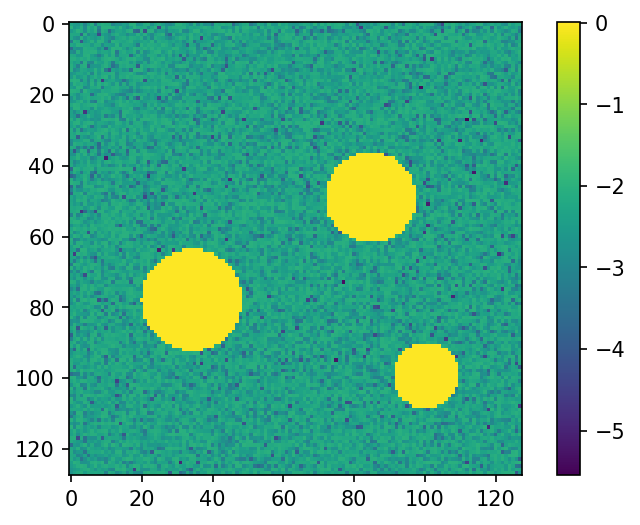

In [11]:
from skimage import draw

x, y = 10, 30
r = 10
noise = 0.01

nx = 128
arr = np.zeros((nx, nx))
xx, yy = np.meshgrid(np.arange(nx),np.arange(nx))

for j in range(3):
    x, y = (np.random.rand(2)-0.5)*nx*0.75
    rad = np.random.randn() * r/5. + r
    rr, cc = draw.circle(nx/2+x, nx/2+y, radius=rad, shape=arr.shape)
    arr[rr, cc] += 1
    
arr += noise*np.random.rand(nx,nx)
plt.imshow(np.log10(arr))
plt.colorbar()
# plt.show()


In [30]:
%%time
## Define a projection function
freqs = np.fft.fftfreq(nx)
freqs = np.fft.fftshift(freqs)[nx/4:3*nx/4]


nbuv = 50
uu, vv = np.zeros((2,nbuv))

cosmat = np.zeros((nx*nx,nbuv))
sinmat = np.zeros((nx*nx,nbuv))

print 'Initializing matrix'
for j in range(nbuv):
    uu[j], vv[j] = np.random.choice(freqs,size=2,replace=True) # choose some sparse Fourier samples
    cosmat[:,j] = np.cos((xx*uu[j]+yy*vv[j])).flatten()
    sinmat[:,j] = np.sin((xx*uu[j]+yy*vv[j])).flatten()

print 'Matrix initialized'


Initializing matrix
Matrix initialized
CPU times: user 51.2 ms, sys: 7.16 ms, total: 58.4 ms
Wall time: 55.6 ms


In [31]:
cos_obs = np.dot(arr.flatten(),cosmat)/arr.sum()
sin_obs = np.dot(arr.flatten(),sinmat)/arr.sum()

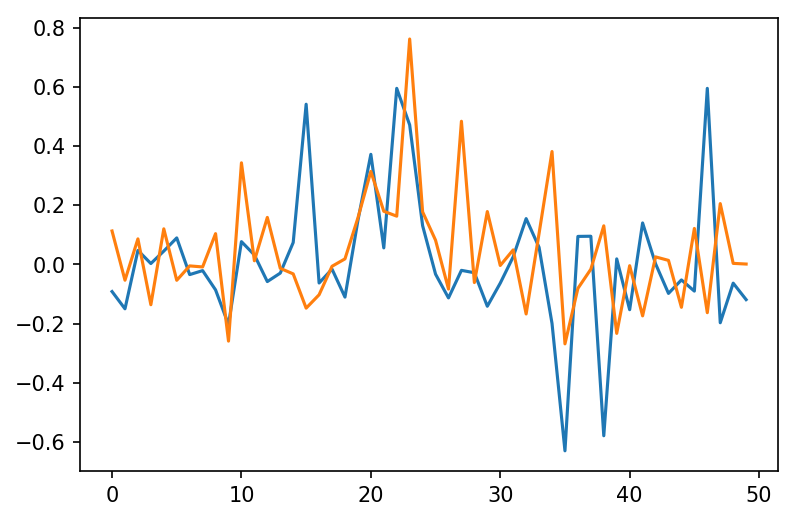

In [85]:
plt.plot(cos_obs)
plt.plot(sin_obs)

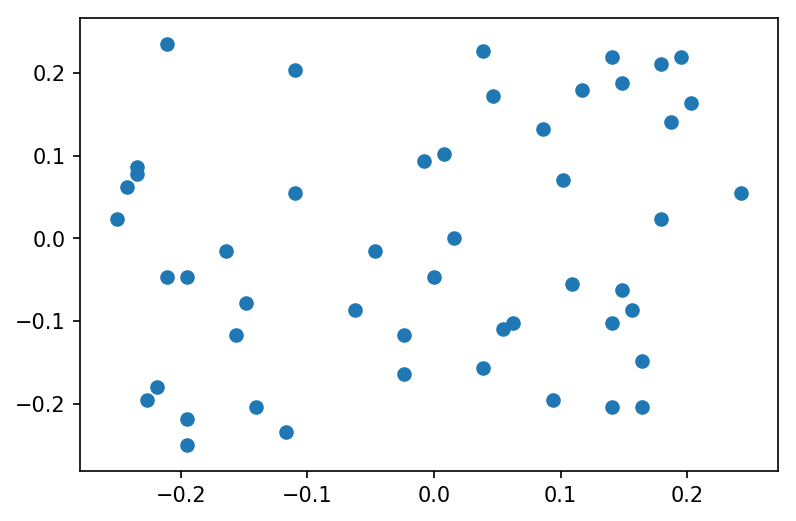

In [86]:
plt.scatter(uu,vv)

In [106]:
# do a direct synthesis image
toy = np.zeros(nx*nx)
for j in range(nbuv):
    toy += cosmat[:,j]*cos_obs[j]
    toy += sinmat[:,j]*sin_obs[j]
    
toy = toy.reshape((nx,nx))
toy = (toy-toy.min())/(toy.max()-toy.min())+0.0001

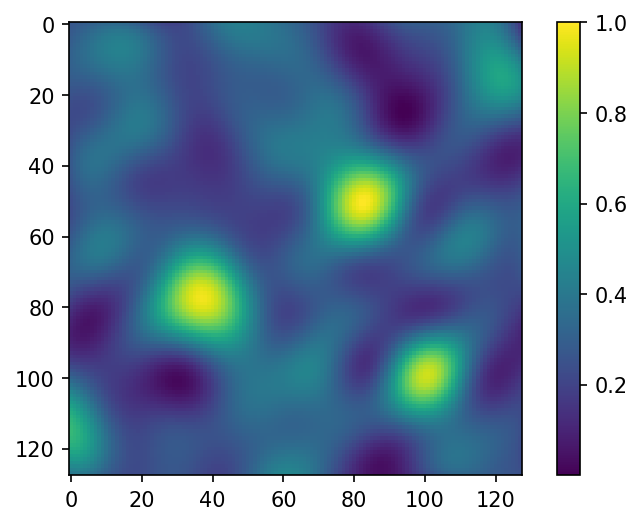

In [107]:
plt.imshow(toy)
plt.colorbar()

## Now let's use TensorFlow!

In [108]:
import tensorflow as tf
print("Using TensorFlow version {0}".format(tf.__version__))
T = tf.float64


Using TensorFlow version 1.7.0-dev20180223


In [199]:
# create tensor to hold cosine and sine projection operators
cos_tensor = tf.constant(cosmat,dtype=T)
sin_tensor = tf.constant(sinmat,dtype=T)

# create tensor to hold your data
cosobs_tensor = tf.constant(cos_obs,dtype=T)
sinobs_tensor = tf.constant(sin_obs,dtype=T)

# create tensor to hold cosine and sine projection operators
cos_err_tensor = tf.constant(np.median(cos_obs)/5.,dtype=T)
sin_err_tensor = tf.constant(np.median(sin_obs)/5.,dtype=T)

# create tensor to hold your image model
# log_image_tensor = tf.Variable(-5*np.ones((arr.shape[0],arr.shape[1],1)), dtype=T)
log_image_tensor = tf.Variable(np.log(toy[:,:,np.newaxis]), dtype=T)
image_tensor = tf.exp(log_image_tensor)

# create constant to hold your TV tuning parameter
tv_alpha = tf.constant(5.e2,dtype=T)

# create constant to hold your entropy tuning parameter

ent_alpha = tf.constant(0,dtype=T)

In [200]:
# Test Total Variation on a real image
# feed_dict = {
#     image_tensor: arr[:,:,np.newaxis],  
# }

feed_dict = {
    log_image_tensor: np.log(arr[:,:,np.newaxis]),  
}


with tf.Session() as session:
    # This step is needed to set up the variables.
    session.run(tf.global_variables_initializer())
    
    # And compute the log likelihood.
    print("Total Variation computed using tensorflow: {0}"
          .format(session.run(tf.image.total_variation(image_tensor),feed_dict=feed_dict)))

Total Variation computed using tensorflow: 394.951134323


In [201]:
def tf_log_like(image,cos_op,sin_op,cos_data,sin_data,cos_err,sin_err):
#     tv = tf.image.total_variation(image)
    dummy = tf.reshape(image,[-1])
#     entropy = tf.reduce_mean(-tf.reduce_sum(image* tf.log(image), axis=1))

    sin_model = tf.tensordot(dummy,sin_op,axes=1)
    cos_model = tf.tensordot(dummy,cos_op,axes=1)
    chi2 = -0.5*tf.reduce_sum(((sin_data-sin_model)/sin_err)**2 + ((cos_data-cos_model)/cos_err)**2)
    return chi2

def tf_entropy(image):
    return tf.reduce_mean(-tf.reduce_sum(image* tf.log(image), axis=1))

log_like = tf_log_like(image_tensor,cos_tensor,sin_tensor,cosobs_tensor,sinobs_tensor,cos_err_tensor,sin_err_tensor)

In [202]:
# Test our likelihood function


feed_dict = {
    log_image_tensor: np.log(toy[:,:,np.newaxis]),  
}

with tf.Session() as session:
    # This step is needed to set up the variables.
    session.run(tf.global_variables_initializer())
    
    # And compute the log likelihood.
    print("Log-likelihood computed using tensorflow: {0}"
          .format(session.run(log_like,feed_dict=feed_dict)))

Log-likelihood computed using tensorflow: -3.43455268163e+12


In [203]:
# now get the gradient
grad = tf.gradients(log_like, [image_tensor])


In [204]:
# %%time
neg_log_like = -log_like + tv_alpha*tf.image.total_variation(image_tensor)

opt = tf.contrib.opt.ScipyOptimizerInterface(
    neg_log_like, var_list=[log_image_tensor])

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    print("Initial log likelihood: {0}".format(session.run(log_like)))
    opt.minimize(session)
    print("Final log likelihood: {0}\n".format(session.run(log_like)))
    
    params = session.run([image_tensor])


Initial log likelihood: -3.43455268163e+12
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 121.396259
  Number of iterations: 12774
  Number of functions evaluations: 12795
Final log likelihood: -3.63911090293



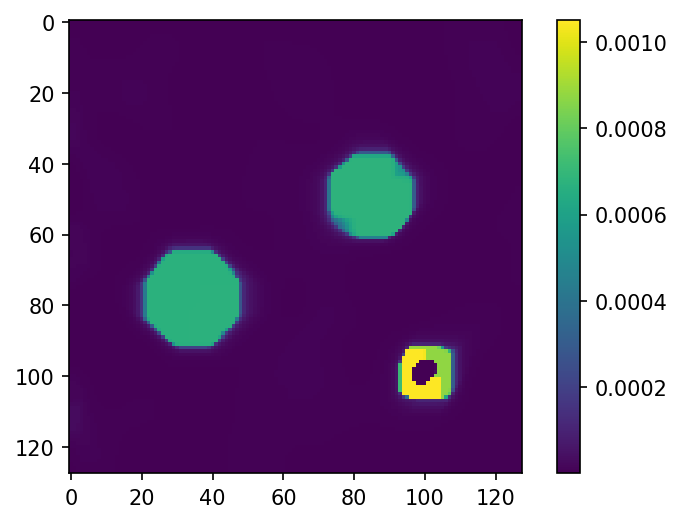

In [205]:
plt.imshow(params[0][:,:,0])
plt.colorbar()

In [209]:
model_cos = np.dot(params[0][:,:,0].flatten(),cosmat)
model_sin = np.dot(params[0][:,:,0].flatten(),sinmat)

Text(0,0.5,u'Coefficient')

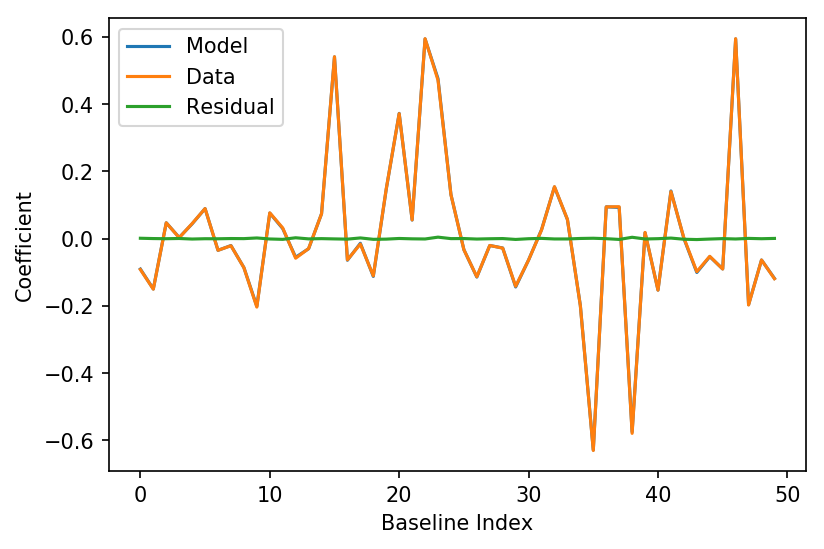

In [221]:
plt.plot(model_cos,label="Model")
# plt.plot(model_sin)
plt.plot(cos_obs,label="Data")

plt.plot(model_cos-cos_obs,label='Residual')
plt.legend()
plt.xlabel("Baseline Index")
plt.ylabel("Coefficient")

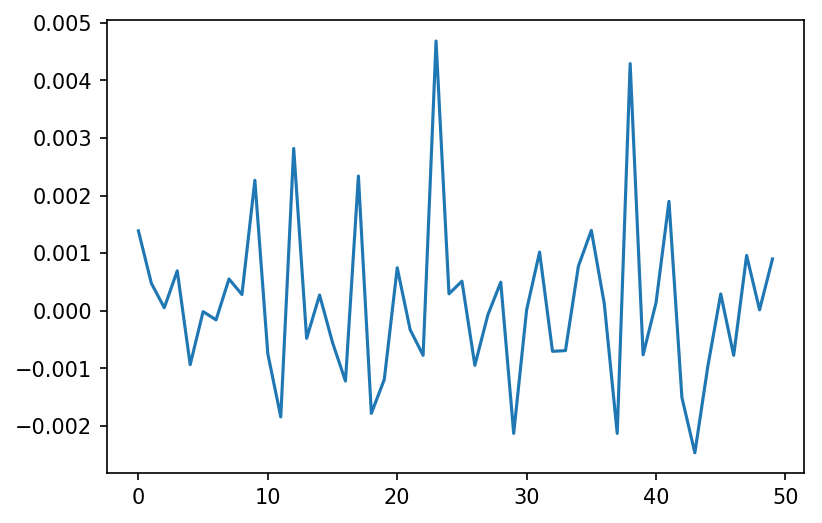